In [1]:
import sys
import os
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import metpy.calc as mpc
from metpy.units import units
# for animations
from PIL import Image

In [2]:
# aggregation indices
os.chdir('/data2/willytsai/python_module')
import conorgidx_revise as agi
from SCAI_calc4obj import labeled_obj, SCAI_calc
from COP_calc4obj import COP
from MICA_calc4obj import MICA
import conorgidx as agi_ori

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def read_data(data_dir,t_start=-360):
    os.chdir(data_dir)
    print(data_dir)
    file_name = glob('*nc')
    data_zon = xr.open_dataset('cm1out_zonmean.nc')
    data_3d = xr.open_dataset('cm1out_sub3d.nc')
    data_2d = xr.open_dataset('cm1out_2Dvars.nc')
    
    # 3d data
    th3d = data_3d.th[t_start:,:30,:,:]    
    u3d = data_3d.uinterp[:,:20,:,:]
    v3d = data_3d.vinterp[:,:20,:,:]

    # zonal mean data
    th = data_zon.th[t_start:,:,:,:]
    qv = data_zon.qv[t_start:,:,:,:]
    u = data_zon.uinterp[t_start:,:,:,:]
    v = data_zon.vinterp[t_start:,:,:,:]
    w = data_zon.winterp[t_start:,:,:,:]
    qc = data_zon.qc[t_start:,:,:,:]
    qi = data_zon.qi[t_start:,:,:,:]
    prs = data_zon.prs[t_start:,:,:,:]
    # 2d data
    prate = data_2d.prate[t_start:,:,:]
    pwat = data_2d.pwat[t_start:,:,:]
    cwp = data_2d.cwp[t_start:,:,:]
    cape = data_2d.cape[t_start:,:,:]
    cin = data_2d.cin[t_start:,:,:]
    
    # temperature conversion
    T = th/((1000*100/prs)**(287.15/1004))-273.15 # [degC]
    # density 
    ro = prs/(287.15*(T+273.15))

    x_dim = data_2d.lon
    y_dim = data_2d.lat
    div = np.gradient(v,y_dim*1000,axis=2) # du/dx+dv/dy 
    vor = -np.gradient(u,y_dim*1000,axis=2) # -du/dy+dv/dx
    #relative humidty calculation, Buck (1996)
    es_liq = 0.61121*np.exp((18.678-T/234.5)*(T/(257.14+T)))*10 #[hpa]
    es_ice = 0.61115*np.exp((23.036-T/333.7)*(T/(279.82+T)))*10

    qs_liq = 0.622*es_liq/(prs/100-es_liq)
    qs_ice = 0.622*es_ice/(prs/100-es_ice)

    rh = qv/qs_liq
    rh_ice = qv/qs_ice

    rh = rh.values.flatten()
    rh_ice = rh_ice.values.flatten()
    T_test = T.values.flatten()

    rh[T_test<0] = rh_ice[T_test<0]
    rh = rh.reshape((T.shape[0],T.shape[1],T.shape[2],T.shape[3]))
    rh = xr.DataArray(rh,coords=[T.time,T.lev,T.lat,T.lon],dims=['time','lev','lat','lon'])
    
    return (th,T,qv,qc,qi,rh,prate*3600*24,pwat*1000,cwp,u,v,w,div,vor,cape,cin,prs,ro,th3d,u3d,v3d)

In [6]:
# get weather or weather2 
#server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/'
server = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne'
os.chdir(server)

exp_name = ['CM1_RAD4K_MPI_SFXint',
            'CM1_RAD4K_RCEP_240x240_lowU05',
            'CM1_RAD4K_RCEP_240x240_lowU07',
            'CM1_RAD4K_RCEP_240x240_lowU10',
            'CM1_RAD4K_RCEP_240x240_lowU15']

print(exp_name)
print('Number of Exp: ', len(exp_name))

['CM1_RAD4K_MPI_SFXint', 'CM1_RAD4K_RCEP_240x240_lowU05', 'CM1_RAD4K_RCEP_240x240_lowU07', 'CM1_RAD4K_RCEP_240x240_lowU10', 'CM1_RAD4K_RCEP_240x240_lowU15']
Number of Exp:  5


In [7]:
(th1,T1,qv1,qc1,qi1,rh1,prate1,pwat1,cwp1,u1,v1,w1,div1,vor1,cape1,cin1,prs1,ro1,th1_3d,u1_3d,v1_3d) = read_data(server+'/'+exp_name[0])
(th2,T2,qv2,qc2,qi2,rh2,prate2,pwat2,cwp2,u2,v2,w2,div2,vor2,cape2,cin2,prs2,ro2,th2_3d,u2_3d,v2_3d) = read_data(server+'/'+exp_name[1])
(th3,T3,qv3,qc3,qi3,rh3,prate3,pwat3,cwp3,u3,v3,w3,div3,vor3,cape3,cin3,prs3,ro3,th3_3d,u3_3d,v3_3d) = read_data(server+'/'+exp_name[2])
(th4,T4,qv4,qc4,qi4,rh4,prate4,pwat4,cwp4,u4,v4,w4,div4,vor4,cape4,cin4,prs4,ro4,th4_3d,u4_3d,v4_3d) = read_data(server+'/'+exp_name[3])
(th5,T5,qv5,qc5,qi5,rh5,prate5,pwat5,cwp5,u5,v5,w5,div5,vor5,cape5,cin5,prs5,ro5,th5_3d,u5_3d,v5_3d) = read_data(server+'/'+exp_name[4])

/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_MPI_SFXint
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU05
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU07
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU10
/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/CM1_RAD4K_RCEP_240x240_lowU15


In [13]:
exp_label = ['CTRL','U05','U07','U10','U15']

In [14]:
fig_out = '/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/fig_sum/'

### Cold pool intensity calculation
cold pool = vint_(theta_purt/theta_env)dz

In [ ]:
# from functools import partial
# from multiprocessing import Pool

In [ ]:
# tmp = th2_3d[500,:,:,:]
# buoy = 9.8*(tmp-tmp.mean(('lat','lon')))/tmp.mean(('lat','lon')) # g*th'/th_env
# buoy_re = np.reshape(buoy.values,(len(buoy.lev),len(x_dim)*len(y_dim)))
# cp_den = np.zeros((len(x_dim)*len(y_dim)))

# for i in range(len(cp_den)):
#     idx = np.where(buoy_re[:,i]<-0.005)[0]  # H = highest altitude of −0.005 m s−2
#     h=0
#     for n in range(len(idx)-1):
#         if (idx[n+1] - idx[n]) <=2: # allowing one discontinuity
#             h = idx[n+1]
#         else:
#             break
#     if h > 0:        
#         cp_den[i] = np.sqrt(2*np.trapz(-buoy_re[:h+1,i],z_dim[:h+1]*1000)) # cold pool speed[m/s]

In [ ]:
# a = np.reshape(cp_den,(len(x_dim),len(y_dim)))

In [ ]:
# fig = plt.figure(figsize=(8,7))

# plt.pcolor(x_dim,y_dim,a,cmap='GnBu',vmin=0,vmax=15)
# cbar = plt.colorbar(shrink=0.7)
# cbar.set_label('Cold pool intendsity [m/s]',fontsize=13)
# plt.contour(x_dim,y_dim,prate2[500,:,:],levels=[10,20],colors=['m'])

In [10]:
def coldpool_intensity(buoy_1d,t):
    
    for i in range(len(x_dim)*len(y_dim)):
        
        idx = np.where(buoy_1d[t,:,i]<-0.005)[0]  # H = highest altitude of −0.005 m s−2
        h = 0
        for n in range(len(idx)-1):
            if (idx[n+1] - idx[n]) <=2: # allowing one discontinuity
                h = idx[n+1]
            else:
                break
        if h > 0:    
            buoy_1d[t,h:,i] = 0
    
    cp_int = np.sqrt(2*np.trapz(-buoy_1d[t,:,:],z_dim[:30]*1000,axis=0))
    
    return cp_int

In [12]:
%%time

for n,th_3d in enumerate([th1_3d,th2_3d,th3_3d,th4_3d,th5_3d]):
    
    t_dim = th_3d.time
    y_dim = th_3d.lat
    x_dim = th_3d.lon
    z_dim = th_3d.lev
    cp_intensity = np.empty((len(t_dim),len(y_dim),len(x_dim)))*np.nan

    tmp = th_3d
    buoy = 9.8*(tmp-tmp.mean(('lat','lon')))/tmp.mean(('lat','lon')) # g*th'/th_env
    buoy_1d = np.reshape(buoy.values,(len(t_dim),len(buoy.lev),len(y_dim)*len(x_dim)))

    for t in range(len(t_dim)):

        cp_array = coldpool_intensity(buoy_1d,t)
        cp_intensity[t,:,:] = np.reshape(cp_array,(len(y_dim),len(x_dim)))
        
    np.save(server+'/coldpool_intensity_'+exp_label[n],cp_intensity)
    print('SAVED: ',exp_label[n])

SAVED:  CTRL
SAVED:  U05
SAVED:  U07
SAVED:  U10
SAVED:  U15
CPU times: user 11min 51s, sys: 54.6 s, total: 12min 45s
Wall time: 14min 25s


In [ ]:
# %%time
# # multiprocessing 
# for n, th_3d in enumerate([th1_3d,th2_3d]):
    
#     cp_intensity = np.empty((len(t_dim),len(x_dim),len(y_dim)))*np.nan
    
#     for t in range(len(t_dim)):
#         print(t)
        
#         if __name__ == "__main__":

#             tmp = th_3d[t,:,...]
#             buoy = 9.8*(tmp[:,...]-tmp[:,...].mean(('lat','lon')))/tmp[:,...].mean(('lat','lon'))
#             buoy_1d = np.reshape(buoy.values,(buoy.shape[0],len(x_dim)*len(y_dim)))

#             pool = Pool()
#             func = partial(coldpool_intensity,buoy_1d)
#             time_result = pool.map(func, range(len(x_dim)*len(y_dim)), chunksize=8000)
#             pool.close()
#             pool.join()
        
#         cp_intensity[t,:,:] = np.reshape(np.asarray(time_result),(len(x_dim),len(y_dim)))
    
#     np.save('coldpool_intensity_'+exp_label[n],cp_intensity)

### cold poo intenstity: load data

In [15]:
os.chdir('/data2/willytsai/cm1r19.8/analysis/runs_cheyenne/')

In [16]:
color_label=['k','r','g','b','m']

In [18]:
cp_int1 = np.load('coldpool_intensity_CTRL.npy')
cp_int2 = np.load('coldpool_intensity_U05.npy')
cp_int3 = np.load('coldpool_intensity_U07.npy')
cp_int4 = np.load('coldpool_intensity_U10.npy')
cp_int5 = np.load('coldpool_intensity_U15.npy')

Text(0, 0.5, '[km]')

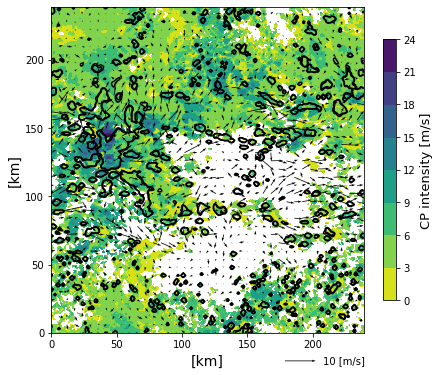

In [19]:
fig = plt.figure(figsize=(7,6))

y_dim, x_dim = np.arange(cp_int3.shape[1]),np.arange(cp_int3.shape[2])

x_mesh,y_mesh = np.meshgrid(x_dim,y_dim)

plt.contourf(x_dim,y_dim,cp_int3[300,:,:],cmap='viridis_r')
cbar = plt.colorbar(shrink=0.8)
cbar.set_label('CP intensity [m/s]',fontsize=13)
plt.contour(x_dim,y_dim,prate3[300,:,:],levels=[10,20],colors=['k'])
Q = plt.quiver(x_mesh[::6,::6],y_mesh[::6,::6],u3_3d[300,10,::6,::6].values,v3_3d[300,10,::6,::6].values)
qk = plt.quiverkey(Q, 0.65, 0.06, 10, r'10 [m/s]', labelpos='E',
                   coordinates='figure')

plt.xlabel('[km]',fontsize=14)
plt.ylabel('[km]',fontsize=14)
#fig.savefig(fig_out+'coldpool_snapshot.png',dip=200,bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(9,3.5))

for n,(cp_int,w) in enumerate(zip([cp_int2,cp_int3,cp_int4],
                             [w2,w3,w4])):
    cp_int_y = np.nanmean(cp_int[-144:,:,:],axis=(0,2))
    ax.plot(y_dim,cp_int_y,color=color_label[n])
ax.set_ylabel('Cold pool intensity [m/s]',fontsize=13)
ax.set_xlabel('y dimension [km]',fontsize=13)
ax.grid(linestyle=':')
#ax.set_ylim([4.5,5.5])#;ax.set_xlim([0,431])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(exp_name[1:],frameon=False,ncol=2)
#plt.savefig(fig_out+'coldpool_intensity_crosssect.png',dpi=200,bbox_inches='tight')

### cold pool stats - size, number

Text(0.5, 1.0, 'U15')

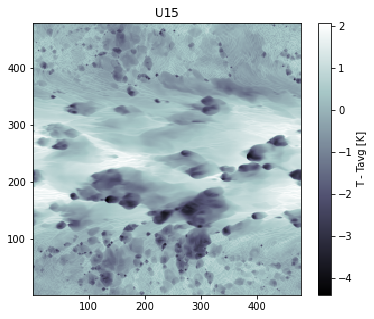

In [54]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
t = -20
cp = (th5_3d[t,0,:,:]-th5_3d[t,0,:,:].mean(('lat','lon'))).values
#cp[cp>-1] = 0                                     
plt.pcolormesh(th4_3d.lon,th4_3d.lat,cp,
            cmap='bone')
cbar = plt.colorbar()
cbar.set_label('T - Tavg [K]')
plt.title(exp_label[4])

In [21]:
def coldpool_stats(cp_array,cp_int=-1.5):
    """ cold pool statistics for two regimes
        cpsize_s: shear [list]
        cpsize_ns: non-shear [list]
        num_feature_s: float
        num_feature_ns: float
    """
    cp_array[cp_array>cp_int] = 0 
    cp_all = -cp_array # turn into positive
    
    # central region 
    cp_sub_s = cp_all[len(y_dim)//4:len(y_dim)//4*3,:]
    cp_sub_ns = np.concatenate([cp_all[:len(y_dim)//4,:],cp_all[-len(y_dim)//4:,:]],axis=0)
    
    # number, size
    labeled_array_s, num_feature_s = labeled_obj(cp_sub_s,cri=1,flag=1)
    labeled_array_ns, num_feature_ns = labeled_obj(cp_sub_ns,cri=1,flag=1)
    
    cpsize_s = []
    cpsize_ns = []
    for n in np.arange(1,num_feature_s+1):
        cpsize_s.append(len(np.where(labeled_array_s == n)[0]))
        
    for n in np.arange(1,num_feature_ns+1):
        cpsize_ns.append(len(np.where(labeled_array_ns == n)[0]))
        
    return cpsize_s, cpsize_ns, num_feature_s, num_feature_ns

In [22]:
tmp = (th3_3d[200,0,:,:]-th3_3d[200,0,:,:].mean(('lon','lat'))).values
cpsize_s, cpsize_ns, num_feature_s, num_feature_ns = coldpool_stats(tmp,cp_int=-1.5)

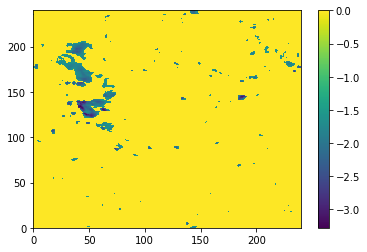

In [23]:
tmp = (th3_3d[300,0,:,:]-th3_3d[300,0,:,:].mean(('lon','lat'))).values
tmp[tmp>-1.5] = 0
plt.pcolormesh(tmp)
plt.colorbar()

In [24]:
# stats for all experiments
timesteps = 144

# stats arrays 
cpsize_bins = np.linspace(0,80,41)
cpsize_dist_s = np.zeros((len(exp_name),len(cpsize_bins)-1)) # size distribution
cpsize_dist_ns = np.zeros((len(exp_name),len(cpsize_bins)-1))
cpnum_s = np.empty((len(exp_name),timesteps))
cpnum_ns = np.empty((len(exp_name),timesteps))

for n,exp in enumerate(exp_name):
    print(exp)
    data = xr.open_dataset(server+'/'+exp+'/cm1out_sub3d.nc')
    th3d = data.th[-timesteps:,:,:,:] # last two days 
    t_dim = th3d.time
    
    for t in range(len(t_dim)):
        cp_array = (th3d[t,0,:,:] - th3d[t,0,:,:].mean(('lon','lat'))).values # cold pools, tha < -1
        cpsize_s, cpsize_ns, num_feature_s, num_feature_ns = coldpool_stats(cp_array,cp_int=-1.5)
        
        # only cold pools > 2 pixels
        cpsize_s = np.asarray(cpsize_s)
        cpsize_s = cpsize_s[cpsize_s>2]
        cpsize_ns = np.asarray(cpsize_ns)
        cpsize_ns = cpsize_ns[cpsize_ns>2]
        
        cpnum_s[n,t] = len(cpsize_s)
        cpnum_ns[n,t] = len(cpsize_ns)
        for i in range(len(cpsize_bins)-1):
            idx = np.where(np.logical_and(cpsize_s>cpsize_bins[i],cpsize_s<=cpsize_bins[i+1]))[0]
            cpsize_dist_s[n,i] += len(idx)
        for i in range(len(cpsize_bins)-1):
            idx = np.where(np.logical_and(cpsize_ns>cpsize_bins[i],cpsize_ns<=cpsize_bins[i+1]))[0]
            cpsize_dist_ns[n,i] += len(idx)

CM1_RAD4K_MPI_SFXint
CM1_RAD4K_RCEP_240x240_lowU05
CM1_RAD4K_RCEP_240x240_lowU07
CM1_RAD4K_RCEP_240x240_lowU10
CM1_RAD4K_RCEP_240x240_lowU15


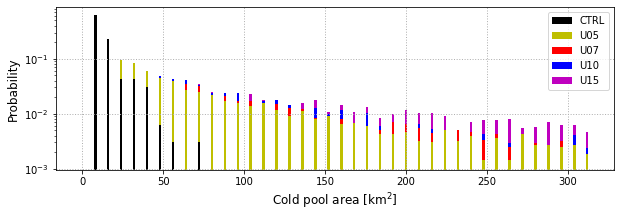

In [28]:
exp_label = ['CTRL','U05','U07','U10','U15']

fig = plt.figure(figsize=(10,3))
colors = ['k','y','r','b','m']
for n in range(len(exp_name)):
    plt.bar(4*cpsize_bins[:-1],cpsize_dist_s[n,:]/np.sum(cpnum_s[n,:])
            ,color=colors[n],zorder=-n,width=1.5,label=exp_label[n])
plt.yscale('log')
plt.ylabel('Probability',fontsize=12)
plt.xlabel('Cold pool area [km$^2$]',fontsize=12)
plt.grid(linestyle=':',linewidth=1)
plt.legend()

In [29]:
cpsize_bins = np.linspace(0,60,31)
cpsize_dist_s = np.zeros(30) # size distribution
cpsize_dist_ns = np.zeros(30) 
cpnum_s = np.empty(10)
cpnum_ns = np.empty(10)

for t in range(10):
    cp_array = (th1_3d[t,0,:,:] - th1_3d[t,0,:,:].mean(('lon','lat'))).values # cold pools, tha < -1
    cpsize_s, cpsize_ns, num_feature_s, num_feature_ns = coldpool_stats(cp_array,cp_int=-1.5)

    cpnum_s[t] = num_feature_s
    cpnum_ns[t] = num_feature_ns
    
    for i in range(len(cpsize_bins)-1):
        idx = np.where(np.logical_and(cpsize_s>cpsize_bins[i],cpsize_s<=cpsize_bins[i+1]))[0]
        cpsize_dist_s[i] += len(idx)
    for i in range(len(cpsize_bins)-1):
        idx = np.where(np.logical_and(cpsize_ns>cpsize_bins[i],cpsize_ns<=cpsize_bins[i+1]))[0]
        cpsize_dist_ns[i] += len(idx)